## Guide: Finding topologies showing Near-Perfect adaptation

In this notebook we apply our genetic algorithm with guided gradient descent to find topologies showing Near-Perfect adaptation. For more details on the single steps, check also `synthetic_evolution_sensitivity.ipynb`. 

In [48]:
using SynthEvo

# load the CRN
C = make_FullyConnectedNonExplosive_CRN(3)
t0 = 10.
t1 = 20.
input = 1.

# prepare ODE problems for the state and sensitivities
base_problem_ode = make_base_problem_for_FCNE_CRN(C, C.ext_ode, t0, input) # this is faster to compute
base_problem_ext = make_base_problem_for_FCNE_CRN(C, C.ext_ode, t0, input)

nothing

#### Near-Perfect Adaptation setup

We will omit some details as they are already coveres in the guide `symbolic_gradient_descent.ipynb`.

In [49]:
# set up the loss function for near-perfect adaptation
loss1 = SynthEvo.adaptation_loss(C, 1, 3, 10., 20.)
loss2 = SynthEvo.sensitivity_loss(C, 1, 3, 0.25, 10., 10.5)
loss3 = SynthEvo.steady_state_loss(C, 2, 10., 20., 6, 16.)
loss4 = SynthEvo.regularization_loss(C, 1)
l = SynthEvo.weighted_loss([loss1, loss2, loss3, loss4], [10,10,100,0.1])


perturbation_list = [0, 0.25, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7, 8]

gd_options = (
    n_iter = 100,
    verbose = false,
    use_random_perturbation = false, # TODO maybe move to perturbation_options
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_gradient_noise = false,
    fraction_gradient_noise = 0.01,
    alpha = 0.1,
    use_adam = false,
    ADAM_beta1 = 0.9,
    ADAM_beta2 = 0.9,
    use_adagrad = true
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = perturbation_list
)

ga_options = (
    genetic_pool_size = 100,
    elite = 10,
    worst = 20,
    death_rate = 0.05,
    mutation_rate = 0.30,
    gradient_mutation_rate = 0.01,
    duplication_rate = 0.20,
    crossover_rate = 0.1,
    max_generations = 10,
    p_cross = 0.1,
    dp = 0.01,
)

ga_perturbation_options = (
    use_random_perturbation = false,
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = perturbation_list
)

mutate_with_GD = (p) -> SynthEvo.symbolic_gradient_descent(p, C, gd_options, gd_perturbation_options).parameters

ga_loss = SynthEvo.prepare_GA_loss(C, base_problem_ode, ga_perturbation_options)

nothing

### running the genetic algorithm

This can be simply done by initializing a random state and then calling the `symbolic_evolve` function iteratively, as follows:

In [50]:
using ProgressBars

state = initialize_state(C.number_of_parameters, ga_options)

max_generations = ga_options.max_generations
iter = ProgressBar(1:max_generations)
for i in iter
    state = symbolic_evolve(ga_loss, state, mutate_with_GD, ga_options)
    set_postfix(iter, avg_loss=state.history.mean_loss[end], best_loss=state.history.best_loss[end])
end

nothing

0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
10.0%┣┫ 1/10 [00:12<Inf:Inf, InfGs/it, avg_loss: 6.708419250596945, best_loss: 5.970378846713095]
20.0%┣┫ 2/10 [00:16<02:10, 16s/it, avg_loss: 6.700766824914024, best_loss: 5.946032748506721]
30.0%┣┫ 3/10 [00:22<01:18, 11s/it, avg_loss: 6.362013384627301, best_loss: 5.940363658776776]
40.0%┣┫ 4/10 [00:27<00:53, 9s/it, avg_loss: 6.258201520842199, best_loss: 5.923751398042814]
50.0%┣┫ 5/10 [00:31<00:38, 8s/it, avg_loss: 6.11856020240894, best_loss: 5.80339629722578]
60.0%┣┫ 6/10 [00:35<00:28, 7s/it, avg_loss: 6.010748377231209, best_loss: 3.5875764722061874]
70.0%┣┫ 7/10 [00:39<00:19, 6s/it, avg_loss: 5.86014113852618, best_loss: 3.2267426707128677]
80.0%┣┫ 8/10 [00:46<00:13, 7s/it, avg_loss: 5.5961295878105, best_loss: 3.2267426707128677]
90.0%┣┫ 9/10 [00:53<00:07, 7s/it, avg_loss: 5.060203603711284, best_loss: 2.4853450334525315]
100.0%┣┫ 10/10 [01:00<00:00, 7s/it, avg_loss: 4.101353142176482, best_loss: 

### Plotting the results

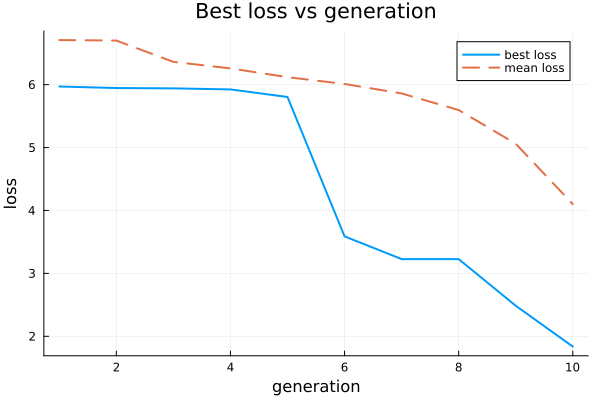

In [51]:
plot_history(state)

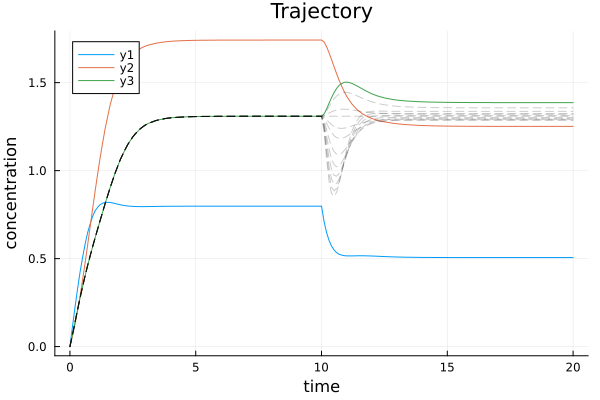

In [52]:
opt_index = argmin(state.fitness)

SynthEvo.quick_trajectory_plot(C, state.pool[opt_index], 1, gd_perturbation_options.perturbation_list, t0, t1, 3)

### Evaluating the homeostatic coefficients

we can compute and plot the homeostatic coefficient for each of the networks in the genetic pool.

This helps in discriminating between IFF and NFB like topologies:

In [53]:
homeostatic_coefs = [
    compute_homeostatic_coefficient(C, p, 1, 2.5, 10., 20.)
    for p in state.pool
]

nothing

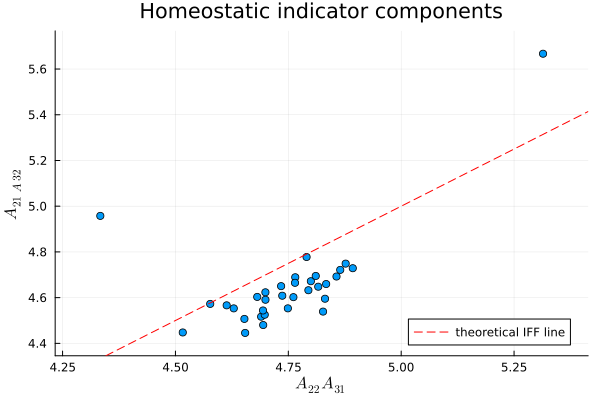

In [61]:
using LaTeXStrings, Plots
# we remove the outliers (networks that are not adapting)
x = [h.A_22_A_31 for h in homeostatic_coefs if abs(h.coefficient)<1.0]
y = [h.A_21_A_32 for h in homeostatic_coefs if abs(h.coefficient)<1.0]
scatter(x, y, title="Homeostatic indicator components", xlabel=L"A_{22}A_{31}", ylabel=L"A_{21}_A_{32}", legend=false, label=false)
plot!([-1000, 1000], [-1000, 1000], color=:red, linestyle=:dash, label="theoretical IFF line", legend=:bottomright)
xlims!(minimum(x)-0.1, maximum(x)+0.1)
ylims!(minimum(y)-0.1, maximum(y)+0.1)